On importe d'abord les packages utiles et le réseaux de neurone "VGG" dont l'article parle :

> We used thefeature  space  provided  by  the  16  convolutional  and  5  pooling  layers  of  the  19  layer  VGG-Network.



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy
import numpy as np

from tqdm.notebook import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# On importe le réseau vgg19 et on fait en sorte qu'il ne soit pas modifié pendant la descente de gradient
vgg = models.vgg19(pretrained=True).features
AvgPool = True
for i, layer in enumerate(vgg):
    if isinstance(layer, nn.ReLU):
        vgg[i] = nn.ReLU(inplace=False)
    if AvgPool and isinstance(layer, nn.MaxPool2d):
        # On remplace les MaxPool par des AvgPool, comme dit dans l'article
        vgg[i] = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
for param in vgg.parameters():
    param.requires_grad_(False)
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU()
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU()
  (18): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (19): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (20): ReLU()
  (21): Conv2d(512, 512

Ce réseau prend en entré des images de taille au moins $224 \times 224$. On ne considérera que des images ayant au moins cette taille. En lisant la documentation, on obtient les valeurs de normalisation de notre échantillon : 
`mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]`
La méthode est la suivante :

* On importe deux images : $\vec c$ l'image dont on veut conserver le contenu mais pas le style et $\vec s$ l'image dont on veut atteindre le style.
* On génère une image aléatoire $\vec x$ de moyenne `mean` et de variance `std`.
* On définit deux fonctions de loss $\mathcal L_{\text{content}}(\vec c, \vec x)$ et $\mathcal L_{\text{style}}(\vec s, \vec x)$ dépendant des output de chaque layer de notre réseau. On définit la loss totale comme une conbinaison convexe des deux précédentes : $\mathcal L(\vec x) = \alpha \mathcal L_{\text{content}}(\vec c, \vec x) + \beta \mathcal L_{\text{style}}(\vec s, \vec x)$.
* On va chercher alors par une méthode de descente de gradient à minimiser $\mathcal L$ en $\vec x$. Ce minimiseur sera notre image de sortie.

# Importation des images

J'ai choisi d'utiliser d'abord les mêmes images que dans l'article. On va crop les images de l'article de manière à avoir deux images de même taille.

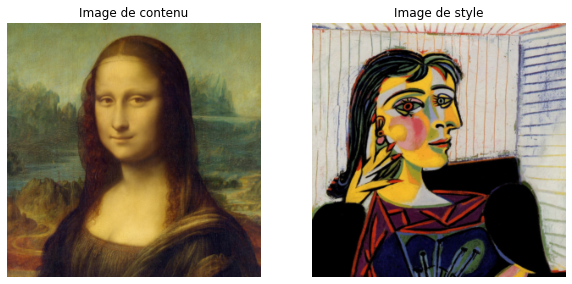

In [2]:
c = Image.open(r"C:\Users\My-pr\Desktop\joconde_0.jpg")
s = Image.open(r"C:\Users\My-pr\Desktop\picasso.jpg")

size = 300

l = np.min([c.size[0]]+ [s.size[0]])
h = np.min([c.size[1]]+ [s.size[1]])
crop = np.min((l,h))

preprocess = transforms.Compose([
    transforms.Resize((h,l)),
    transforms.CenterCrop((crop,crop)),
    transforms.Resize((size,size)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])

# On rajoute une dimension puisque le réseau prend en entré des batchs
c = preprocess(c)[None,:,:,:].float().to(device).detach()
s = preprocess(s)[None,:,:,:].float().to(device).detach()

# print(s.shape)

def imshow(tensor, title = None):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image* np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    if title is not None:
        plt.title(title)
    plt.axis(False)
    plt.imshow(image)
def list_im_conv(images):
    re = []
    for im in images:
        image = im.to("cpu").clone().detach()
        image = image.numpy().squeeze()
        image = image.transpose(1,2,0)
        image = image* np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
        image = image.clip(0, 1)
        re.append(image)
    return re

plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
imshow(c, "Image de contenu")
plt.subplot(1,2,2)
imshow(s,"Image de style")
#plt.savefig(r"C:\Users\Paul\Desktop\fig1.jpg")

# Définition des loss
On a importé le cnn `vgg` sous forme de `nn.Sequential`. On a besoin de calculer les matrices de gram pour la loss de style :

In [3]:
def gram(input): # Retourne une matrice de gram formée des éléments de x
    a, b, c, d = input.size()
    F_xl = input.view(a* b, c * d)
    G = torch.mm(F_xl, F_xl.t())
    return G.div(a * b * c * d)

Pour une liste de layers donnée, on récupère les différentes valeurs en sortie de chaque layer :

In [4]:
# On lit dans l'article qu'ils ont utilisé les layers suivant :
default_layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2', # L'unique layer du contenu
                  '28': 'conv5_1'}
layersconv2_2 = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '6': 'conv2_2',# L'unique layer du contenu
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '28': 'conv5_1'}
def get_layers_values(image, model, layers=layersconv2_2):
    values = {}
    x = image
    # Dans le vgg de pytorch, les différents layers sont étiquetés par des nombres '0', '1'...
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            values[layers[name]] = x    
    return values


Il est possible d'utiliser deux images initiales :
* on peut considérer un bruit blanc
* ou alors on considère l'image c de contenu, et ce n'est pas abhérent puisque l'on sait que l'on veut conserver le contenu de cette image le long des itérations.

In [5]:
# Deux conditions intiales possibles :
x = torch.randn([1,3,size,size], device=device,requires_grad=True)
#x = c.clone().requires_grad_(True).to(device)

On choisit enfin les poids de chacun des layers, ainsi que le poids qu'on associe à chacune des loss pour la loss finale :
$$
\mathcal L_{\text{totale}} = \alpha \mathcal L_{\text{content}} + \beta \mathcal L_{\text{style}}
$$

In [6]:
layers_weights = {'conv1_1': 1/5,
                 'conv2_1': 1/5,
                 'conv3_1': 1/5,
                 'conv4_1': 1/5,
                 'conv5_1': 1/5}

# Poids :
alpha = 1
beta = 1e3

On définit aussi une fonction auxilliaire pour faire tous les calculs nécessaires à $\mathcal L_{\text{style}}$

In [7]:
def get_style_loss(x_,layers_weights):
    loss = 0
    for layer in layers_weights:
        aux = x_[layer]
        x_gram = gram(aux)
        s_gram = s_grams[layer]
        loss += 1/4 * F.mse_loss(x_gram,s_gram, reduction = 'sum')
    return loss

# Descente de gradient :
On va alors faire une descente de gradient pour optimiser la loss fonction de $\vec x$.

In [8]:
# On va noter c_, s_ ou x_ l'image obtenue en sortie de chaque layer.
c_ = get_layers_values(c, vgg)
s_ = get_layers_values(s, vgg)
# On calcule en amont les matrices de grams pour l'image s :
s_grams = {layer: gram(s_[layer]) for layer in s_}
# Choix de l'optimizer :
x = torch.randn([1,3,size,size], device=device,requires_grad=True)
optimizer = optim.Adam([x], lr=0.003)
#optimizer = optim.SGD([x], lr=0.003, momentum = 0.3)

In [10]:
# Nombre d'itération de descente de gradient :
nbiter = 15000
imgs=[]
err = []
#mean_c = []
beta = 7
alpha = 1
for i in tqdm(range(nbiter)):
    optimizer.zero_grad()
    x_ = get_layers_values(x, vgg,)
    # L_content :
    content_loss = F.mse_loss(x_['conv2_2'],c_['conv2_2'])
    # L_style :
    style_loss = get_style_loss(x_,layers_weights)
    #mean_c.append(style_loss)
    total_loss = alpha * content_loss + beta * style_loss
    err.append(total_loss)
    total_loss.backward()
    optimizer.step()
    if i % 6250 == 0:
        cop = x.clone().detach()
        imgs.append(cop)

In [ ]:
n = len(imgs)
fig = plt.figure(figsize = (20,10))
re = list_im_conv(imgs)
for i in range(0,n):
    ax = fig.add_subplot(2,4,i+1)
    ax.axis(False)
    ax.set_title("$N =${}".format(i*6250))
    ax.imshow(re[i])
    
plt.savefig(r"C:\Users\My-pr\Desktop\test3168.jpg")

In [ ]:
plt.figure()
plt.yscale("log")
plt.title("$\log L_{totale}$ en fonction du nombre d'itérations")
plt.plot(range(len(err)),err)
plt.savefig(r"C:\Users\My-pr\Desktop\convlog.jpg")

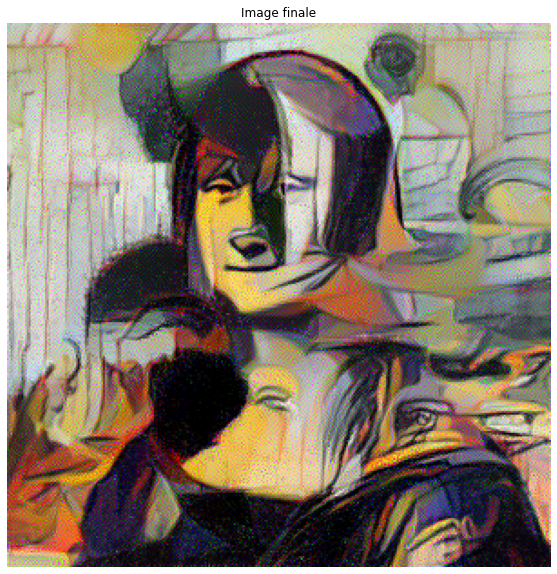

In [11]:
plt.figure(figsize = (10,10))
imshow(x, "Image finale")
plt.savefig(r"C:\Users\My-pr\Desktop\joc_f.jpg")

In [ ]:
# Choix de Beta :
nbiter = 10000
betas = [1,5,10]
images = []
for beta in betas:
    x = torch.randn([1,3,size,size], device=device,requires_grad=True)
    optimizer = optim.Adam([x], lr=0.003)
    for i in tqdm(range(nbiter)):
        optimizer.zero_grad()
        x_ = get_layers_values(x, vgg)
        # L_content :
        content_loss = F.mse_loss(x_['conv2_2'],c_['conv2_2'])
        # L_style :
        style_loss = get_style_loss(x_,layers_weights)
        total_loss = content_loss + beta * style_loss
        total_loss.backward()
        optimizer.step()
    images.append(x)

In [ ]:
fig = plt.figure(figsize = (25,25))
re = list_im_conv(images)
for i in range(len(images)):
    ax = fig.add_subplot(4,4,i+1)
    ax.axis(False)
    plt.title("$\\beta={:.1e}$".format(betas[i]))
    ax.imshow(re[i])
plt.savefig(r"C:\Users\My-pr\Desktop\beta_choix.jpg")

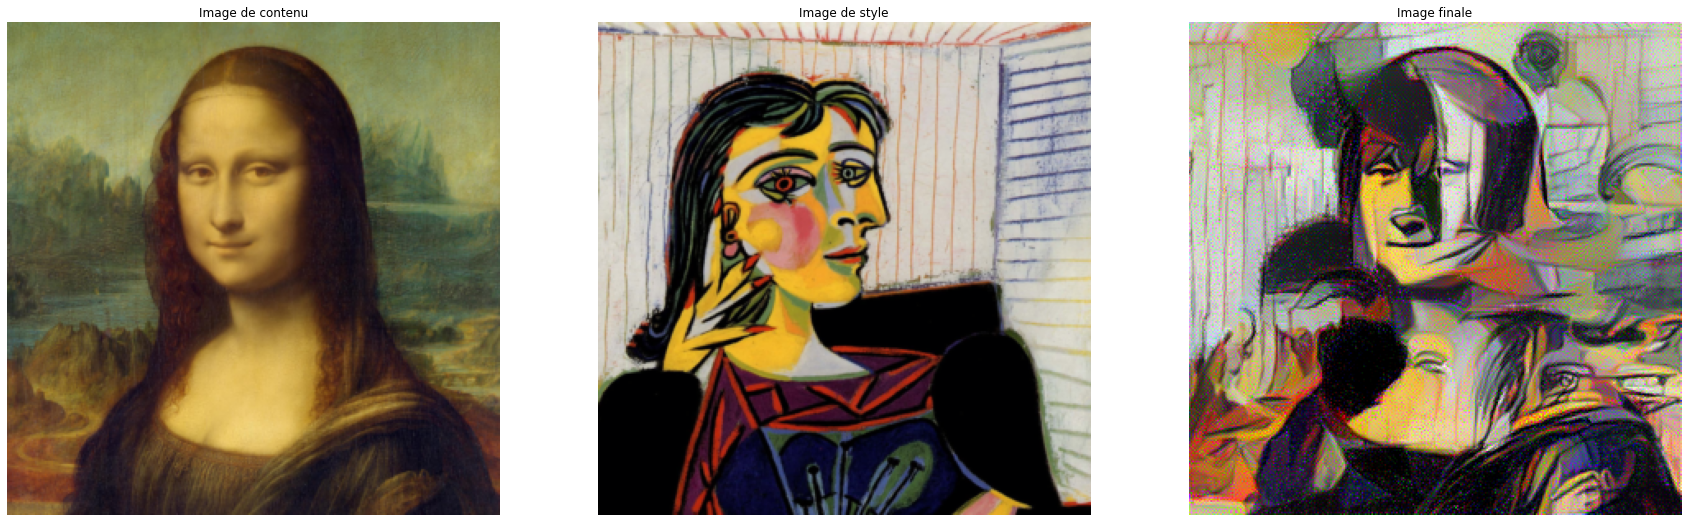

In [13]:
plt.figure(figsize = (30,30))
plt.subplot(1,3,1)
imshow(c,"Image de contenu")
plt.subplot(1,3,2)
imshow(s,"Image de style")
plt.subplot(1,3,3)
imshow(x, "Image finale")

plt.savefig(r"C:\Users\My-pr\Desktop\joc3.jpg")